In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from wind_utils import get_distance, draw_graph, distance_threshold_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data.to_dataframe().reset_index()
df = df.dropna(subset=["PM2.5", "WS", "WD"])
df['WD'] = 270-df['WD']

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
8783,"Anand Vihar, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01 00:00:00,2022-01-01 01:00:00,613.25,NaN,406.70,104.50,387.18,30.1,...,84.15,0.3,97.00,8.95,974.98,11.95,NaN,0.0,28.647622,77.315809
8784,"Anand Vihar, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,684.00,892.0,313.38,73.83,294.77,68.2,...,87.62,0.3,49.50,8.88,974.90,11.52,NaN,0.0,28.647622,77.315809
8785,"Anand Vihar, Delhi - DPCC",2022-01-01 02:30:00,2022-01-01 02:00:00,2022-01-01 03:00:00,615.25,916.5,357.10,66.70,325.20,NaN,...,89.38,0.3,54.25,8.88,974.77,11.38,NaN,0.0,28.647622,77.315809
8786,"Anand Vihar, Delhi - DPCC",2022-01-01 03:30:00,2022-01-01 03:00:00,2022-01-01 04:00:00,739.00,950.0,289.57,70.25,273.48,64.4,...,90.65,0.3,68.25,8.90,974.90,11.15,NaN,0.0,28.647622,77.315809
8787,"Anand Vihar, Delhi - DPCC",2022-01-01 04:30:00,2022-01-01 04:00:00,2022-01-01 05:00:00,596.50,801.5,233.18,60.12,222.10,NaN,...,91.33,0.3,48.00,8.88,974.68,11.05,NaN,0.0,28.647622,77.315809


In [5]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    G = distance_threshold_graph(d, 11)
    node_features, edge_index, y = dataset_generation(G)
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN_RegressionModel(4)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr=0.001)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].squeeze().tolist()
        gnn_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
        #RF
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_rmse = torch.sqrt(torch.mean((torch.tensor(rf_pred) - data.y[data.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_rmse = torch.sqrt(torch.mean((torch.tensor(knn_pred) - data.y[data.test_mask])**2))
        
        #LR
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_rmse = torch.sqrt(torch.mean((torch.tensor(lr_pred) - data.y[data.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_rmse = torch.sqrt(torch.mean((torch.tensor(idw_pred) - data.y[data.test_mask])**2))
        
        #Mean
        train_mean = torch.mean(data.y[data.train_mask])
        mean_pred = int(data.test_mask.sum())*[float(train_mean)]
        mean_rmse = torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "WD": G.nodes[super]["wd"],
                            "WS": G.nodes[super]["ws"],
                            "knn rmse": float(knn_rmse),
                            "mean rmse": float(mean_rmse),
                            "idw rmse": float(idw_rmse),
                            "lr rmse": float(lr_rmse),
                            "rf rmse": float(rf_rmse),
                            "gnn rmse": float(gnn_rmse),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "mean pred": mean_pred[0],
                            "idw pred": idw_pred[0],
                            "lr pred": lr_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN RMSE:  75.82596059945914
Mean RMSE:  67.96446345402644
IDW RMSE:  94.7730593398735
RF RMSE:  79.6633037790152
LR RMSE:  70.54385845477765
GNN RMSE:  90.63133459824782


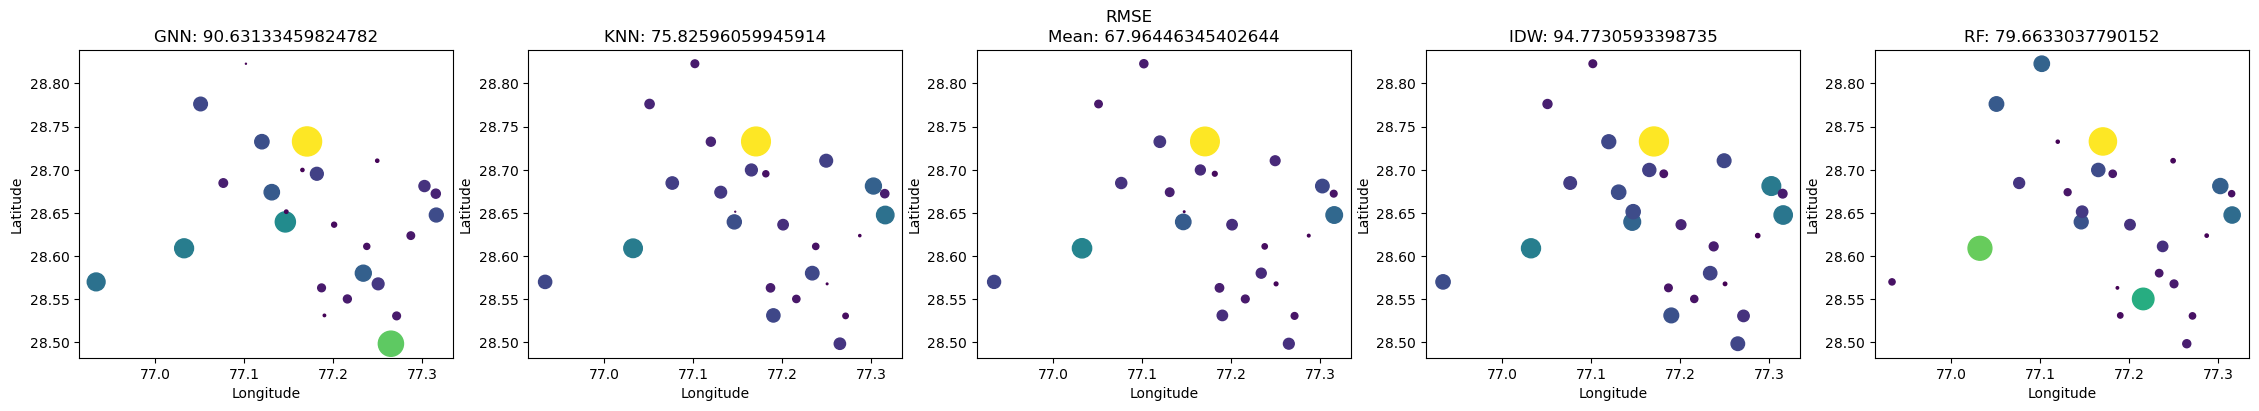

In [6]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-08-15 01:30:00', freq = '10M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN RMSE: ', np.mean(d_i['knn rmse']))
    print('Mean RMSE: ', np.mean(d_i['mean rmse']))
    print('IDW RMSE: ', np.mean(d_i['idw rmse']))
    print('RF RMSE: ', np.mean(d_i['rf rmse']))
    print('LR RMSE: ', np.mean(d_i['lr rmse']))
    print('GNN RMSE: ', np.mean(d_i['gnn rmse']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('RMSE')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['gnn rmse'], c = d_i['gnn rmse'])
    title = 'GNN: ' + str(np.mean(d_i['gnn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['knn rmse'], c = d_i['knn rmse'])
    title = 'KNN: ' + str(np.mean(d_i['knn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['mean rmse'], c = d_i['mean rmse'])
    title = 'Mean: ' + str(np.mean(d_i['mean rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['idw rmse'], c = d_i['idw rmse'])
    title = 'IDW: ' + str(np.mean(d_i['idw rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['rf rmse'], c = d_i['rf rmse'])
    title = 'RF: ' + str(np.mean(d_i['rf rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()